In [ ]:
from abc import ABC, abstractmethod

import numpy as np


class Problem(ABC):
    @abstractmethod
    def __call__(self, x: np.ndarray) -> float:
        """Compute the function value at point x."""
        raise NotImplementedError

    @abstractmethod
    def grad(self, x: np.ndarray) -> np.ndarray:
        """Compute the gradient at point x."""
        raise NotImplementedError


class Sphere(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(x**2)

    def grad(self, x: np.ndarray) -> np.ndarray:
        return 2 * x


class Rosenbrock(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(100.0 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def grad(self, x: np.ndarray) -> np.ndarray:
        grad = np.zeros_like(x)
        n = x.size
        grad[0] = -400 * x[0] * (x[1] - x[0] ** 2) - 2 * (1 - x[0])
        for i in range(1, n - 1):
            grad[i] = (
                200 * (x[i] - x[i - 1] ** 2)
                - 400 * x[i] * (x[i + 1] - x[i] ** 2)
                - 2 * (1 - x[i])
            )
        grad[-1] = 200 * (x[-1] - x[-2] ** 2)
        return grad


class Rastrigin(Problem):
    def __call__(self, x: np.ndarray) -> float:
        A = 10
        n = x.size
        return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

    def grad(self, x: np.ndarray) -> np.ndarray:
        A = 10
        return 2 * x + 2 * np.pi * A * np.sin(2 * np.pi * x)


In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go


def prepare_mesh_grid(
    problem: Problem,
    bounds: tuple[float, float] = (-5.0, 5.0),
    grid_size: int = 50,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    x_vals = np.linspace(bounds[0], bounds[1], grid_size)
    y_vals = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)

    Z = np.zeros_like(X)
    for i in range(grid_size):
        for j in range(grid_size):
            xy = np.array([X[i, j], Y[i, j]])
            Z[i, j] = problem(xy)

    return X, Y, Z, x_vals, y_vals


def plot_3d_surface(
    problem: Problem,
    grid_size: int = 50,
):
    X, Y, Z, _, _ = prepare_mesh_grid(problem=problem, grid_size=grid_size)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")

    ax.set_title(problem.__class__.__name__)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")

    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()


def plot_contour_and_paths(
    problem: Problem,
    paths: list[np.ndarray],
    grid_size: int = 200,
    title: str = "",
):
    """
    Create an interactive contour plot of a 2D function and overlay multiple optimization paths.

    Args:
        problem: An instance of a Problem class.
        paths: List of numpy arrays; each array is of shape (epochs, 2) containing an optimization trajectory.
        title: Title for the plot.
    """
    _, _, Z, x_vals, y_vals = prepare_mesh_grid(problem, grid_size=grid_size)

    fig = go.Figure(
        data=go.Contour(
            x=x_vals,
            y=y_vals,
            z=Z,
            colorscale="Viridis",
            contours=dict(showlines=False),
            colorbar=dict(title="Function Value"),
        )
    )

    for idx, path in enumerate(paths):
        fig.add_trace(
            go.Scatter(
                x=path[:, 0],
                y=path[:, 1],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(width=2, color="black"),
                name=f"Run {idx + 1}",
                showlegend=False,
            )
        )

    fig.update_layout(
        title=title, xaxis_title="x", yaxis_title="y", width=800, height=700
    )

    fig.show()

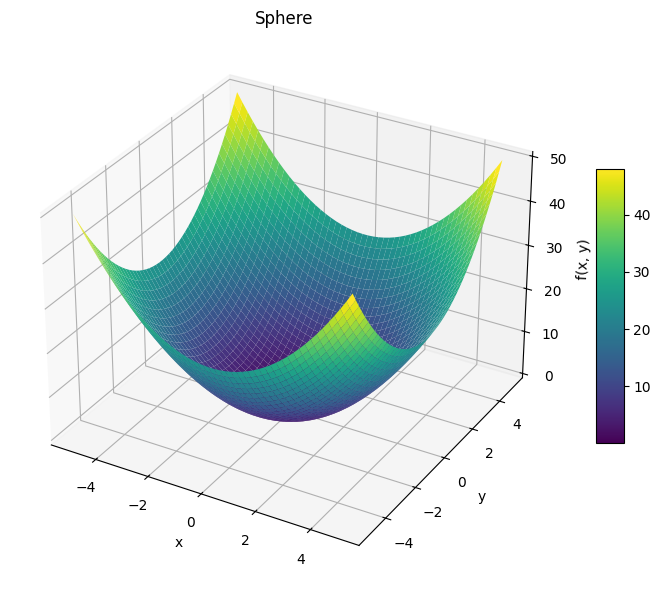

In [5]:
plot_3d_surface(Sphere())

In [7]:
plot_contour_and_paths(Sphere(), paths=[])

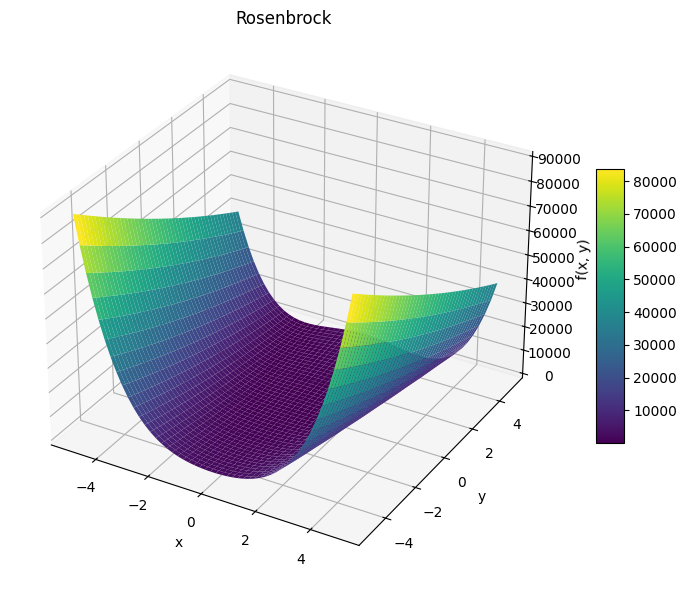

In [8]:
plot_3d_surface(Rosenbrock())

In [9]:
plot_contour_and_paths(Rosenbrock(), [])

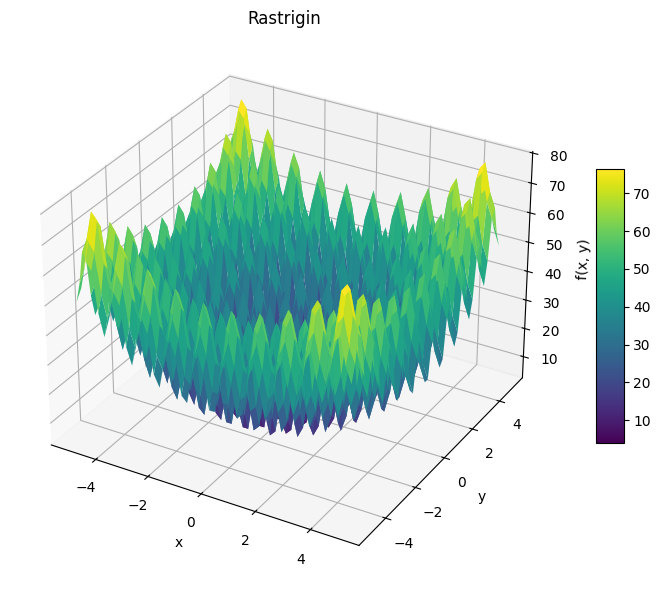

In [10]:
plot_3d_surface(Rastrigin())

In [11]:
plot_contour_and_paths(Rastrigin(), [])

In [98]:
def momentum(
    problem: Problem,
    initial_solution: np.ndarray = np.array([2.0, 2.0]),
    alpha: float = 0.01,
    beta: float = 0.9,
    number_of_epochs: int = 1000,
):
    X = initial_solution.copy()
    v = np.zeros_like(X)
    X_history = [X.copy()]
    v_history = []

    for i in range(number_of_epochs):
        v = beta * v - alpha * problem.grad(X)
        X += v
        v_history.append(np.linalg.norm(v))
        X_history.append(X.copy())

    return X, v, np.array(X_history), v_history


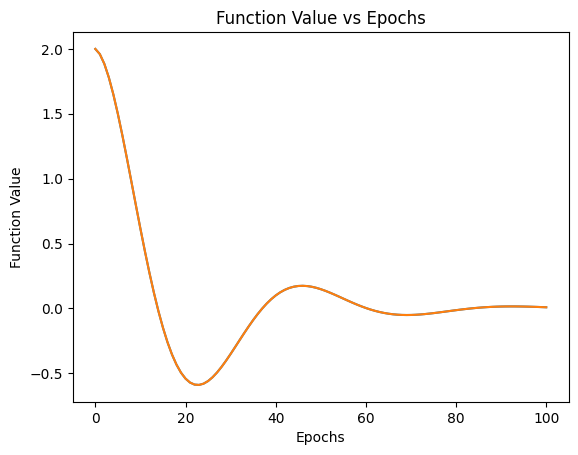

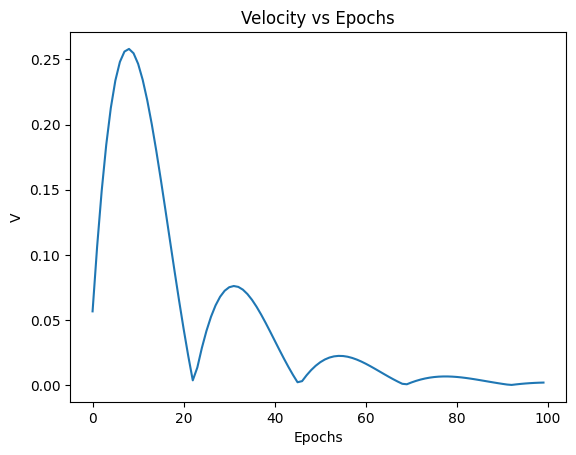

In [74]:
X, v, x_history, v_history = momentum(
    Sphere(), np.array([2.0, 2.0]), 0.01, number_of_epochs=100
)

plt.plot(x_history)
plt.xlabel("Epochs")
plt.ylabel("Function Value")
plt.title("Function Value vs Epochs")
plt.show()

plt.plot(v_history)
plt.xlabel("Epochs")
plt.ylabel("V")
plt.title("Velocity vs Epochs")
plt.show()

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_82774/430869439.py:29: RuntimeWarning:

overflow encountered in scalar multiply

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_82774/3955488804.py:14: RuntimeWarning:

invalid value encountered in subtract



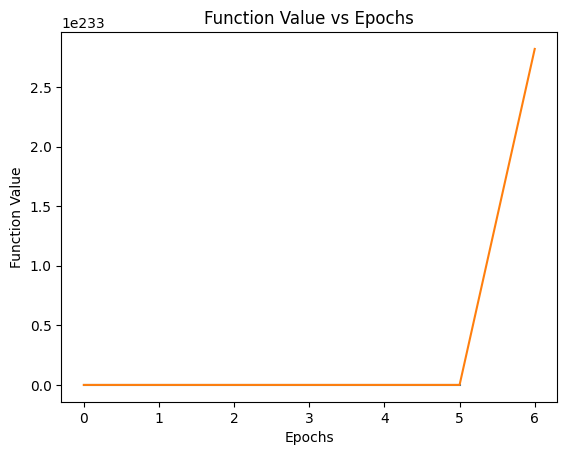

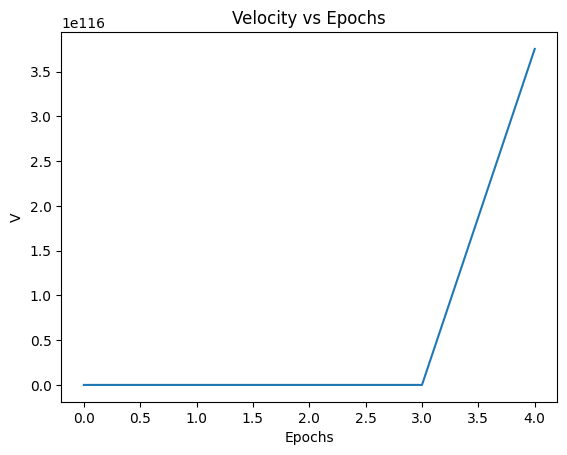

In [81]:
X, v, x_history, v_history = momentum(
    Rosenbrock(), np.array([2.0, 2.0]), alpha=0.01, beta=0.9, number_of_epochs=100
)

plt.plot(x_history)
plt.xlabel("Epochs")
plt.ylabel("Function Value")
plt.title("Function Value vs Epochs")
plt.show()

plt.plot(v_history)
plt.xlabel("Epochs")
plt.ylabel("V")
plt.title("Velocity vs Epochs")
plt.show()

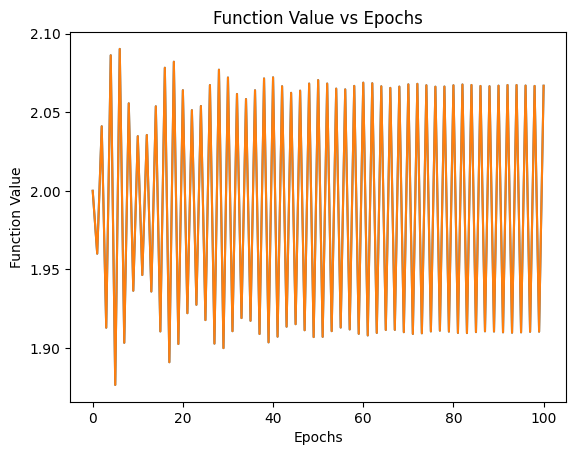

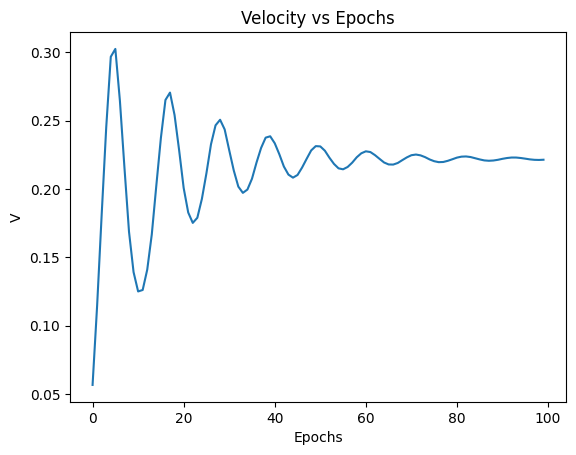

In [82]:
X, v, x_history, v_history = momentum(
    Rastrigin(), np.array([2.0, 2.0]), alpha=0.01, beta=0.9, number_of_epochs=100
)

plt.plot(x_history)
plt.xlabel("Epochs")
plt.ylabel("Function Value")
plt.title("Function Value vs Epochs")
plt.show()

plt.plot(v_history)
plt.xlabel("Epochs")
plt.ylabel("V")
plt.title("Velocity vs Epochs")
plt.show()

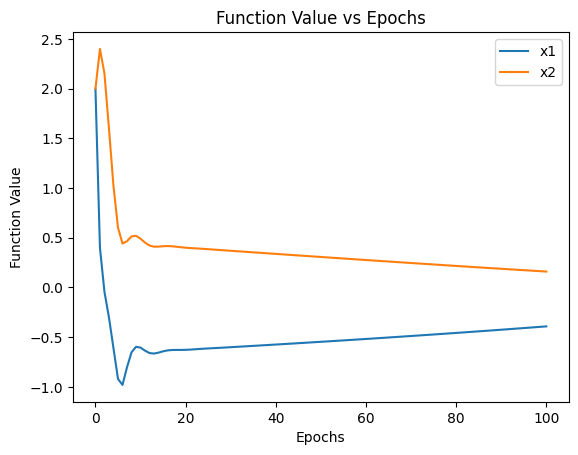

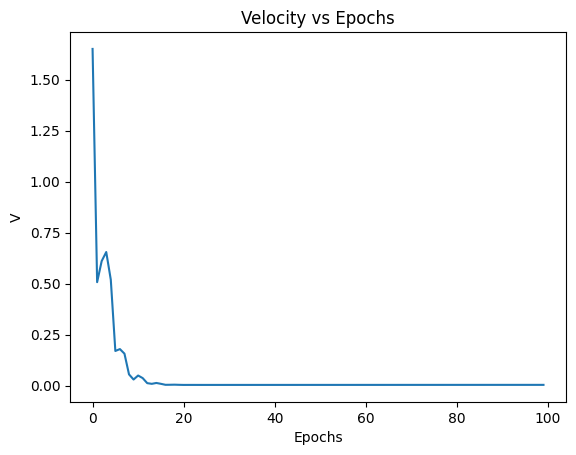

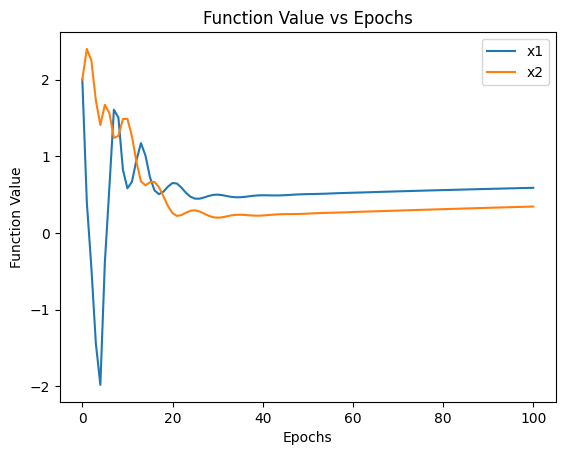

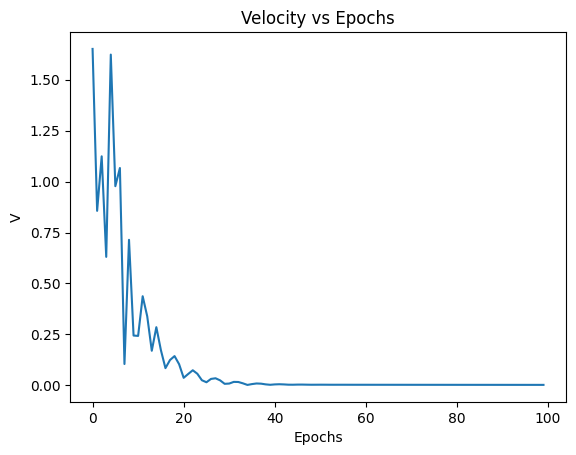

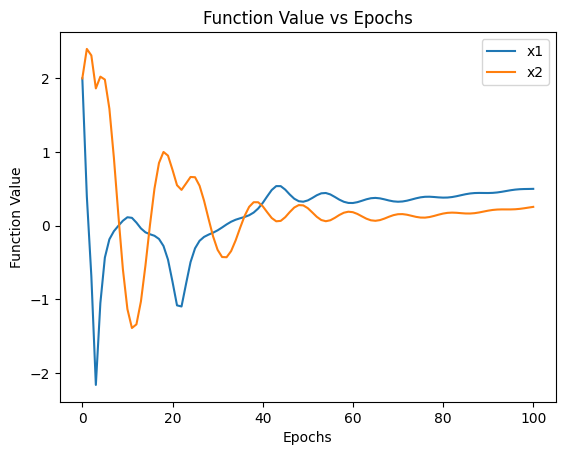

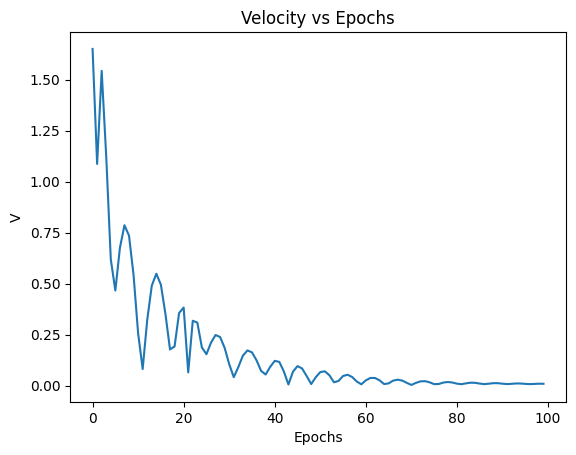

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_82774/430869439.py:29: RuntimeWarning:

overflow encountered in scalar power

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_82774/430869439.py:32: RuntimeWarning:

overflow encountered in scalar power

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_82774/430869439.py:29: RuntimeWarning:

invalid value encountered in scalar subtract

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_82774/430869439.py:32: RuntimeWarning:

invalid value encountered in scalar subtract



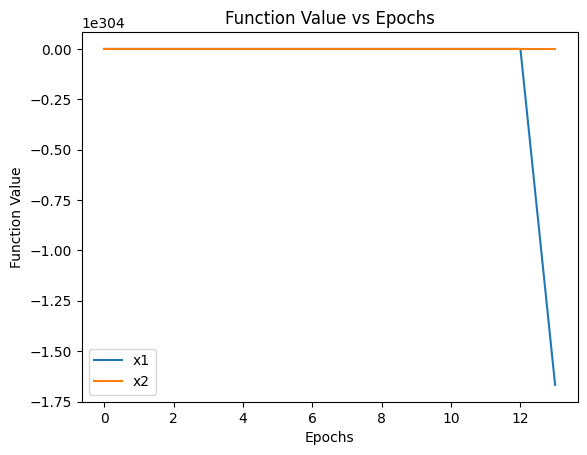

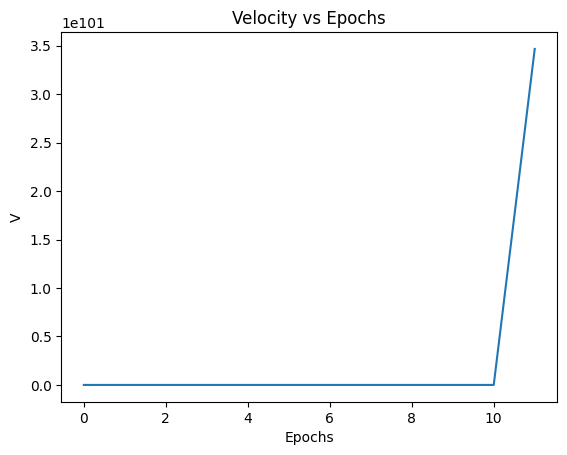

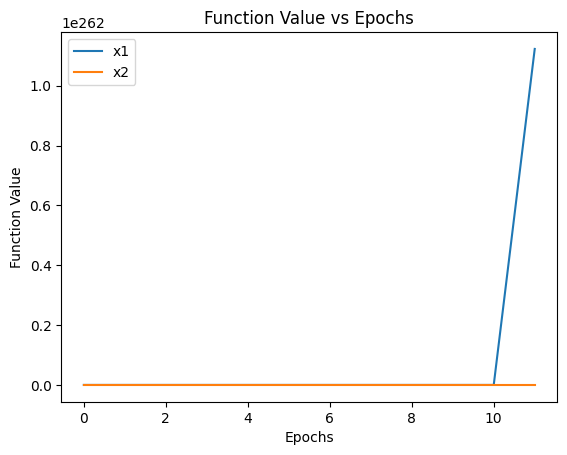

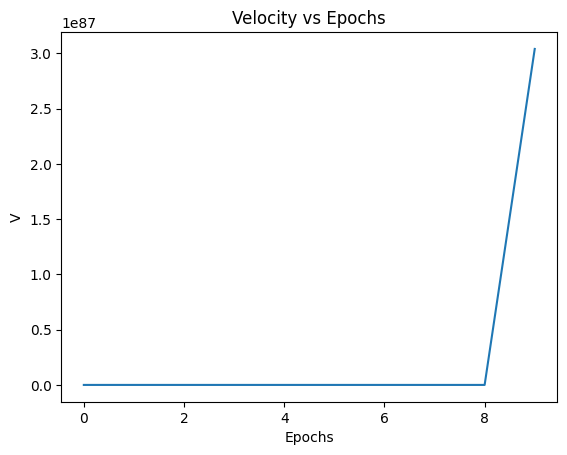

In [84]:
for b in [0.5, 0.75, 0.9, 0.95, 0.99]:
    X, v, x_history, v_history = momentum(
        Rosenbrock(),
        alpha=10e-4,
        beta=b,
        initial_solution=np.array([2.0, 2.0]),
        number_of_epochs=100,
    )
    plt.plot([x[0] for x in x_history], label="x1")
    plt.plot([x[1] for x in x_history], label="x2")
    plt.xlabel("Epochs")
    plt.ylabel("Function Value")
    plt.title("Function Value vs Epochs")
    plt.legend()
    plt.show()

    plt.plot(v_history)
    plt.xlabel("Epochs")
    plt.ylabel("V")
    plt.title("Velocity vs Epochs")
    plt.show()

In [96]:
from math import sqrt


def adam(
    problem: Problem,
    initial_solution: np.ndarray = np.array([2.0, 2.0]),
    alpha: float = 0.01,
    beta1: float = 0.9,
    beta2: float = 0.999,
    number_of_epochs: int = 100,
    epsilon: float = 1e-8,
):
    X = initial_solution.copy()
    v = np.zeros_like(X)
    m = np.zeros_like(X)
    X_history = [X.copy()]

    for i in range(number_of_epochs):
        grad = problem.grad(X)
        m += (1 - beta1) * grad
        v += (1 - beta2) * grad**2
        bias_m = m / (1 - beta1**i)
        bias_v = v / (1 - beta2**i)
        X -= (alpha * bias_m) / (sqrt(bias_v) + epsilon)
        X_history.append(X.copy())

    return np.array(X_history)

In [ ]:
X, v, momentum_X_history, momentum_v_history = momentum(
    Sphere(),
    alpha=0.01,
    beta=0.9,
    initial_solution=np.array([2.0, 2.0]),
    number_of_epochs=100,
)

X, v, adam_X_history, adam_v_history = adam(Sphere())

plot_contour_and_paths(Sphere(), [momentum_X_history, adam_X_history])

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_82774/2601784679.py:22: RuntimeWarning:

divide by zero encountered in divide

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_82774/2601784679.py:23: RuntimeWarning:

divide by zero encountered in divide



TypeError: only length-1 arrays can be converted to Python scalars